# RoML vs. PEARL & VariBAD: MuJoCo Tests

In [1]:
%reload_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import pickle as pkl
import general_utils as utils

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.output_result { max-width:90% !important; }</style>"))
np.set_printoptions(precision=4)
np.set_printoptions(linewidth=150)
np.set_printoptions(suppress=True)

C:\Users\idogr\AppData\Local\Temp\ipykernel_21108\4131318338.py:12: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
ENVS = ['HalfCheetahVel', 'HalfCheetahMass', 'HalfCheetahBody']
HUM_ENVS = ['HumanoidVel', 'HumanoidMass', 'HumanoidBody']
YLIM_AVG = dict(HalfCheetahVel=(None,-450*0), HalfCheetahMass=(1400,1900), HalfCheetahBody=(1400,1800), HumanoidVel=(None,None), HumanoidMass=(None,None), HumanoidBody=(None,None))
YLIM_CVAR = dict(HalfCheetahVel=(None,-1000*0), HalfCheetahMass=(1000,1350), HalfCheetahBody=(700,1000), HumanoidVel=(None,None), HumanoidMass=(None,None), HumanoidBody=(None,None))

ALPHA = 0.05
METHODS = ['base', 'cem']
SEEDS = list(range(30))

In [3]:
def cvar(x, alpha):
    n = int(np.ceil(alpha*len(x)))
    x = sorted(x)[:n]
    return np.mean(x)

method_map = lambda method: 'RoML' if method=='cem' else 'PEARL'

def load_res(env, method, seed):
    fname = f'test_returns_{env}_{method}_{seed}.pkl'
    try:
        with open(f'output/{fname}', 'rb') as fd:
            dd = pkl.load(fd)
    except:
        print(f'Missing file: {fname}')
        return pd.DataFrame()

    task_sample = list(dd['tasks'][0].values())[0]
    n_tasks = len(task_sample) if isinstance(task_sample, (tuple, list, np.ndarray)) else 1
    tasks = np.stack([list(tt.values())[0] for tt in dd['tasks']])
    if n_tasks == 1:
        task_dict = {'task0':tasks}
    else:
        task_dict = {f'task{i}':tasks[:,i] for i in range(n_tasks)}
    task_dict['env'] = env
    task_dict['method'] = method_map(method)
    task_dict['seed'] = seed
    task_dict['ret'] = dd['rets']
    
    return pd.DataFrame(task_dict)

def load_all_res(env, methods, seeds, alpha=0.05):
    dd = pd.DataFrame()
    meths = []
    means = []
    cvars = []
    
    for method in methods:
        for seed in seeds:
            r = load_res(env, method, seed)
            dd = pd.concat((dd, r))
            if len(r):
                meths.append(method_map(method))
                means.append(r.ret.mean())
                cvars.append(cvar(r.ret.values, alpha))
    
    rr = pd.DataFrame(dict(env=env, method=meths, avg_ret=means, cvar_ret=cvars))
    
    dd.reset_index(drop=True, inplace=True)
    rr.reset_index(drop=True, inplace=True)
    return rr, dd

def plot_rets(rr, ylim_avg=None, ylim_cvar=None, save=False):
    env = rr.env.values[0]
    axs = utils.Axes(4, 2, (3.7,3.0), fontsize=15)
    a = 0

    sns.barplot(data=rr, x='method', y='avg_ret', ci=95, capsize=0.1, ax=axs[a])
    if ylim_avg:
        axs[a].set_ylim(ylim_avg)
    axs[a].tick_params(axis='both', which='major', labelsize=13)
    axs.labs(a, 'method', f'mean return')
    a += 1

    sns.barplot(data=rr, x='method', y='cvar_ret', ci=95, capsize=0.1, ax=axs[a])
    if ylim_cvar:
        axs[a].set_ylim(ylim_cvar)
    axs[a].tick_params(axis='both', which='major', labelsize=13)
    axs.labs(a, 'method', f'$CVaR_{{{ALPHA}}}$ return')
    a += 1
    
    utils.qplot(rr, x='seed', hue='method', y='avg_ret', ax=axs[a])
    a += 1

    utils.qplot(rr, x='seed', hue='method', y='cvar_ret', ax=axs[a])
    a += 1

    plt.tight_layout();
    if save:
        plt.savefig(f'output/{env}_summary.png', bbox_inches='tight', dpi=300);
    return axs

def plot_tasks(dd):
    n_tasks = len([c for c in dd.columns if c.startswith('task')])
    for i in range(n_tasks):
        axs = utils.compare_quantiles(dd, f'task{i}', 'ret', 'method', 'env', xbins=11, axs_args=dict(axsize=(4.5,3)))
    return axs

def main(env, save=False):
    rr, dd = load_all_res(env, METHODS, SEEDS)
    rr.to_pickle(f'output/pearl_{env}.pkl')
    plot_tasks(dd)
    axs = plot_rets(rr, YLIM_AVG[env], YLIM_CVAR[env], save)
    return axs

HalfCheetahVel
HalfCheetahMass
HalfCheetahBody
CPU times: total: 4.23 s
Wall time: 4.86 s


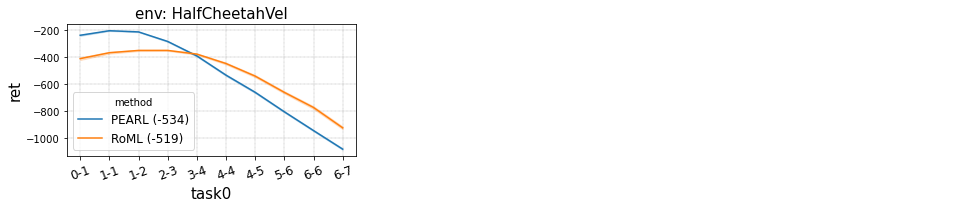

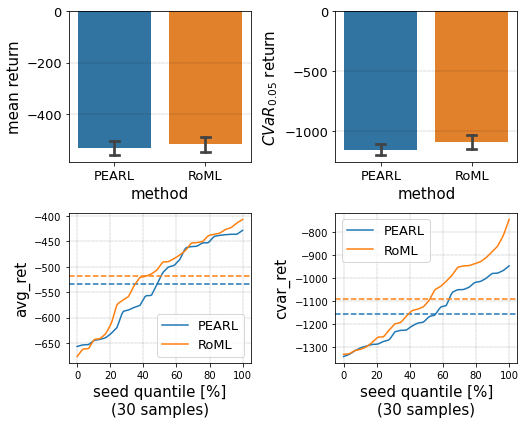

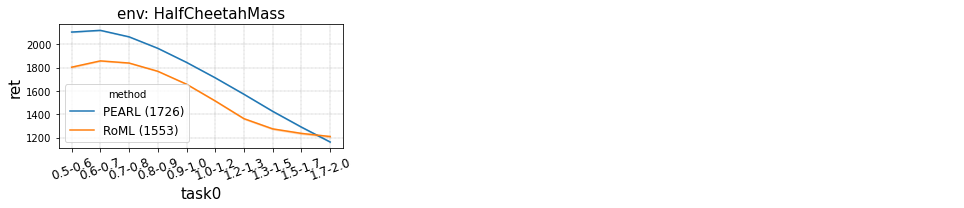

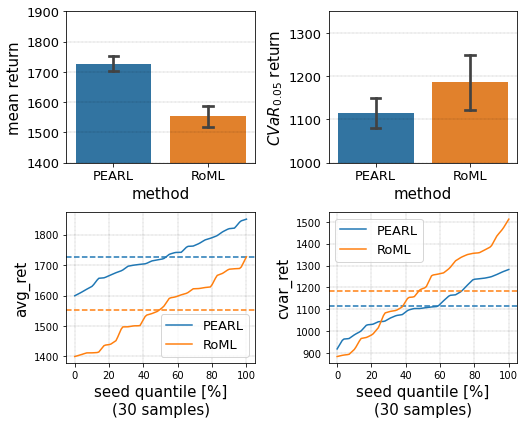

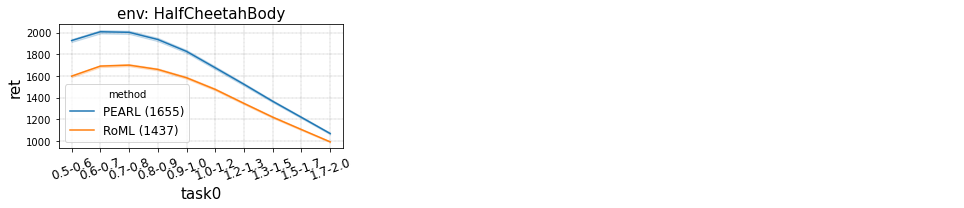

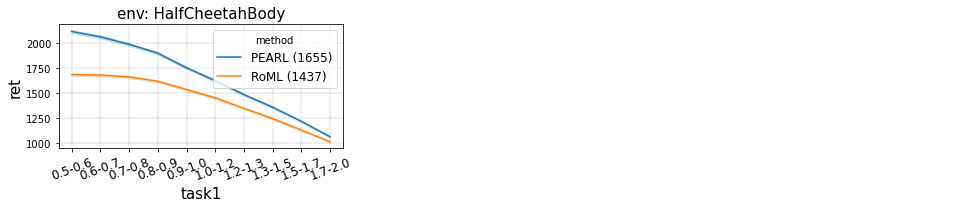

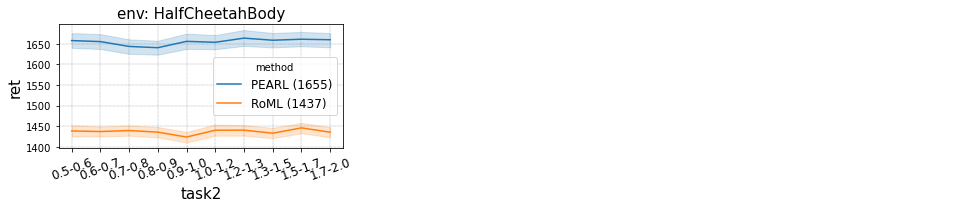

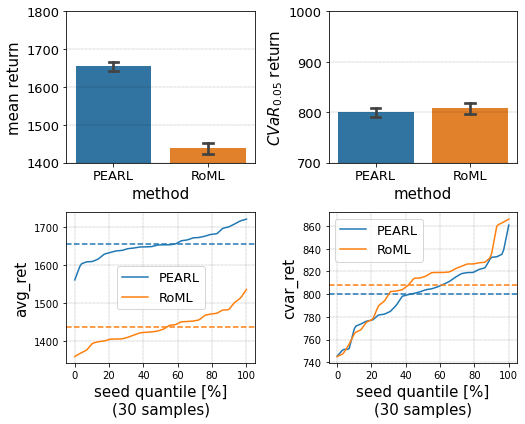

In [4]:
%%time
for env in ENVS:
    print(env)
    axs = main(env, save=False)

## Merge results with VariBAD

In [5]:
def load_both_res(env):
    vv = pd.read_pickle(f'output/varibad_{env}.pkl')
    vv = vv[vv.method!='CVaR-ML']
    vv['baseline'] = 'VariBAD'
    rr = vv
    try:
        pp = pd.read_pickle(f'output/pearl_{env}.pkl')
        pp.drop('env', axis=1, inplace=True)
        pp['baseline'] = 'PEARL'
        rr = pd.concat((rr,pp))
    except:
        print(f'No PEARL in {env}')
    rr['method'] = ['RoML' if m=='RoML' else 'baseline' for m in rr.method]
    return rr

def plot_both_rets(rr, env, ylim_avg=None, ylim_cvar=None, save=False, axs=None, ids=(0,1)):
    if axs is None:
        axs = utils.Axes(2, 2, (3.7,3.0), fontsize=15)
        
    a = ids[0]
    sns.barplot(data=rr, x='baseline', hue='method', y='avg_ret', ci=95, capsize=0.1, ax=axs[a])
    if ylim_avg:
        axs[a].set_ylim(ylim_avg)
    axs[a].tick_params(axis='both', which='major', labelsize=13)
    axs.labs(a, 'method', f'mean return', env)
    axs[a].legend(fontsize=13)

    a = ids[1]
    sns.barplot(data=rr, x='baseline', hue='method', y='cvar_ret', ci=95, capsize=0.1, ax=axs[a])
    if ylim_cvar:
        axs[a].set_ylim(ylim_cvar)
    axs[a].tick_params(axis='both', which='major', labelsize=13)
    axs.labs(a, 'method', f'$CVaR_{{{ALPHA}}}$ return', env)
    axs[a].legend(fontsize=13)

    plt.tight_layout();
    if save:
        plt.savefig(f'output/{env}_summary.png', bbox_inches='tight', dpi=300);
    return axs

def main_both(env, save=False, axs=None, ids=(0,1)):
    rr = load_both_res(env)
    axs = plot_both_rets(rr, env, YLIM_AVG[env], YLIM_CVAR[env], save=save, axs=axs, ids=ids)
    return axs

def main_all_envs(envs, save=False):
    n = len(envs)
    axs = utils.Axes(2*n, n, (3.7,3.0), fontsize=15)
    for i, env in enumerate(envs):
        main_both(env, save=False, axs=axs, ids=(i, n+i))
    if save:
        plt.savefig(f'output/{save}_absolute_returns.png', bbox_inches='tight', dpi=300);
    return axs

CPU times: total: 875 ms
Wall time: 912 ms


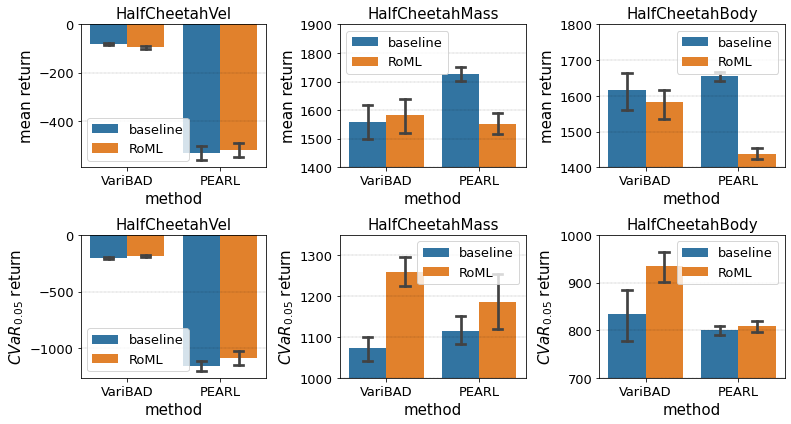

In [6]:
%%time
axs = main_all_envs(ENVS, save='hc')

## Calculate relative returns

In [7]:
def ratio(r, y='cvar_ret', resample=False, sanity=None, paired=True):
    if sanity:
        counts = r.groupby('method').apply(len).values
        if len(counts)!=sanity[0] or np.any(counts!=sanity[1]):
            print(r)
            print(counts)
            raise ValueError()

    if paired:
        n = len(r) // 2
        ids0 = np.arange(n)
        if resample:
            ids0 = np.random.choice(ids0, n, True)
        ids1 = n + ids0
    else:
        ids0 = r[r.method=='baseline'].index.values
        ids1 = r[r.method=='RoML'].index.values
        if resample:
            ids0 = np.random.choice(ids0, len(ids0), True)
            ids1 = np.random.choice(ids1, len(ids1), True)
    
    roml_advantage = r[y].iloc[ids1].mean() - r[y].iloc[ids0].mean()
    return roml_advantage

def ratio_std(r, y):
    n = len(r) // 2
    ids0 = np.arange(n)
    ids1 = n + ids0
    deltas = r[y].iloc[ids1].values - r[y].iloc[ids0].values
    std = np.std(deltas) / np.sqrt(n)
    return std

def bootstrap_ratio(r, y='cvar_ret', B=1000, zval=False, **kwargs):
    x = ratio(r, y, **kwargs)
    if zval:
        std = ratio_std(r, y)
        x1 = x - std
        x2 = x + std
    else:
        X = [ratio(r, y, resample=True, **kwargs) for _ in range(B)]
        x1 = utils.quantile(X, 0.05)
        x2 = utils.quantile(X, 0.95)
    return x, x1, x2

def ratio_df(ENVS, y='cvar_ret', **kwargs):
    bases = []
    envs = []
    rets = []
    for env in ENVS:
        rr = load_both_res(env)
        for baseline in pd.unique(rr.baseline):
            bases.extend(3*[baseline])
            envs.extend(3*[env])
            x = bootstrap_ratio(rr[rr.baseline==baseline], y=y, **kwargs)
            rets.extend(x)
    X = pd.DataFrame(dict(baseline=bases, env=envs, ret=rets))
    return X

def plot_ratios(X1, X2, axsize=(5,3.5)):
    axs = utils.Axes(2, 2, axsize, fontsize=15)
    a = 0

    axs[a].axhline(0, color='k', linewidth=2)
    sns.barplot(data=X1, x='baseline', hue='env', y='ret', ci=99, estimator=np.median, capsize=0.1, ax=axs[a])
    axs.labs(a, 'baseline', 'RoML - baseline', f'Mean-return difference')
    axs[a].set_xticklabels(axs[a].get_xticklabels(), fontsize=14)
    # axs[a].set_yticklabels(axs[a].get_yticklabels(), fontsize=12)
    axs[a].legend(fontsize=13)
    a += 1

    axs[a].axhline(0, color='k', linewidth=2)
    sns.barplot(data=X2, x='baseline', hue='env', y='ret', ci=99, estimator=np.median, capsize=0.1, ax=axs[a])
    axs.labs(a, 'baseline', 'RoML - baseline', f'CVaR$_{{{ALPHA}}}$-return difference')
    axs[a].set_xticklabels(axs[a].get_xticklabels(), fontsize=14)
    # axs[a].set_yticklabels(axs[a].get_yticklabels(), fontsize=12)
    axs[a].legend(fontsize=13)
    a += 1
    
    plt.tight_layout()
    return axs

def plot_ratios2(X1, X2, fsize=(5.3,2.6)):
    fig, axs = plt.subplots(1, 2, sharey=True, figsize=fsize)
    fig.subplots_adjust(wspace=0)
    a = 0

    axs[a].grid(color='k', linestyle=':', linewidth=0.3)
    axs[a].axhline(0, color='k', linewidth=2)
    sns.barplot(data=X1, x='baseline', hue='env', y='ret', ci=99, estimator=np.median, capsize=0.1, ax=axs[a])
    utils.labels(axs[a], '', 'RoML advantage', f'Mean return', fontsize=15)
    axs[a].set_xticklabels(axs[a].get_xticklabels(), fontsize=14)
    axs[a].legend(fontsize=13)#, loc='upper right')
    a += 1

    axs[a].grid(color='k', linestyle=':', linewidth=0.3)
    axs[a].axhline(0, color='k', linewidth=2)
    sns.barplot(data=X2, x='baseline', hue='env', y='ret', ci=99, estimator=np.median, capsize=0.1, ax=axs[a])
    utils.labels(axs[a], '', '', f'CVaR$_{{{ALPHA}}}$ return', fontsize=15)
    axs[a].set_xticklabels(axs[a].get_xticklabels(), fontsize=14)
    axs[a].legend(fontsize=13).remove()
    a += 1

    # plt.savefig(f'output/roml_cheetah_summary.png', bbox_inches='tight', dpi=300);

def main_ratio(ENVS, fsize=(5.3,2.6), **kwargs):
    M = ratio_df(ENVS, 'avg_ret', **kwargs)
    X = ratio_df(ENVS, 'cvar_ret', **kwargs)
    if 1 == len(pd.unique([e[:6] for e in M.env])):
        M['env'] = [e.replace('HalfCheetah','').replace('Humanoid','') for e in M.env]
        X['env'] = [e.replace('HalfCheetah','').replace('Humanoid','') for e in X.env]
    
    plot_ratios2(M, X, fsize)
    return M, X

#### HalfCheetah

In [8]:
%%time
M = ratio_df(ENVS, 'avg_ret', sanity=(2,30))  # verify that in every experiment, there are 2 methods with 30 seeds each
X = ratio_df(ENVS, 'cvar_ret', sanity=(2,30))

CPU times: total: 4.39 s
Wall time: 4.53 s


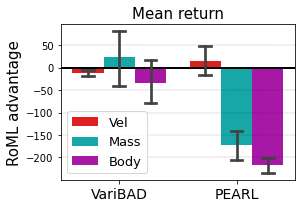

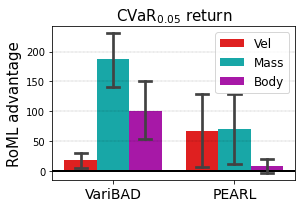

In [9]:
axs = utils.Axes(1, 1, (4.3,3), fontsize=15)
a = 0

XX = X.copy()
XX['env'] = [e[len('halfcheetah'):] for e in XX.env]
MM = M.copy()
MM['env'] = [e[len('halfcheetah'):] for e in MM.env]

colors = dict(Vel='r', Mass='c', Body='m')

axs[a].axhline(0, color='k', linewidth=2)
sns.barplot(data=MM, x='baseline', hue='env', y='ret', ci=99, estimator=np.median, capsize=0.1, palette=colors, ax=axs[a])
axs.labs(a, '', 'RoML advantage', f'Mean return')
axs[a].set_xticklabels(axs[a].get_xticklabels(), fontsize=14)
# axs[a].set_yticklabels(axs[a].get_yticklabels(), fontsize=12)
axs[a].legend(fontsize=13)#.remove()
a += 1

plt.tight_layout();
plt.savefig(f'output/roml_hc_mean.png', bbox_inches='tight', dpi=300);

#################################################

axs = utils.Axes(1, 1, (4.3,3), fontsize=15)
a = 0

axs[a].axhline(0, color='k', linewidth=2)
sns.barplot(data=XX, x='baseline', hue='env', y='ret', ci=99, estimator=np.median, capsize=0.1, palette=colors, ax=axs[a])
axs.labs(a, '', 'RoML advantage', f'CVaR$_{{{ALPHA}}}$ return')
axs[a].set_xticklabels(axs[a].get_xticklabels(), fontsize=14)
# axs[a].set_yticklabels(axs[a].get_yticklabels(), fontsize=12)
axs[a].legend(fontsize=12)
a += 1

plt.tight_layout();
plt.savefig(f'output/roml_hc_cvar.png', bbox_inches='tight', dpi=300);

CPU times: total: 4.52 s
Wall time: 4.63 s


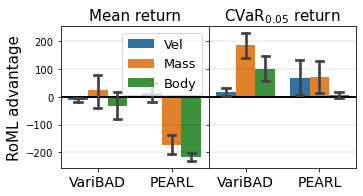

In [11]:
%%time
M, X = main_ratio(ENVS, sanity=(2,30))

#### Humanoid (VariBAD only)

In [12]:
%%time
Mhum = ratio_df(HUM_ENVS, 'avg_ret', paired=1, sanity=(2,30))
Xhum = ratio_df(HUM_ENVS, 'cvar_ret', paired=1, sanity=(2,30))

No PEARL in HumanoidVel
No PEARL in HumanoidBody
No PEARL in HumanoidVel
No PEARL in HumanoidBody
CPU times: total: 2.16 s
Wall time: 2.26 s


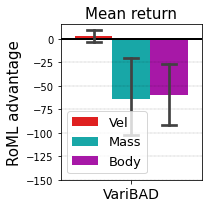

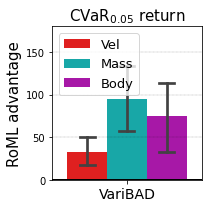

In [13]:
axs = utils.Axes(1, 1, (3,3), fontsize=15)
a = 0

XX = Xhum.copy()
XX['env'] = [e[len('humanoid'):] for e in XX.env]
MM = Mhum.copy()
MM['env'] = [e[len('humanoid'):] for e in MM.env]

colors = dict(Vel='r', Mass='c', Body='m')

axs[a].axhline(0, color='k', linewidth=2)
sns.barplot(data=MM, x='baseline', hue='env', y='ret', ci=99, estimator=np.median, capsize=0.1, palette=colors, ax=axs[a])
axs.labs(a, '', 'RoML advantage', f'Mean return')
axs[a].set_xticklabels(axs[a].get_xticklabels(), fontsize=14)
# axs[a].set_yticklabels(axs[a].get_yticklabels(), fontsize=12)
axs[a].set_ylim((-150, None))
axs[a].legend(fontsize=13, loc='lower left')
a += 1

plt.tight_layout();
plt.savefig(f'output/roml_hum_mean.png', bbox_inches='tight', dpi=300);

#################################################

axs = utils.Axes(1, 1, (3,3), fontsize=15)
a = 0

axs[a].axhline(0, color='k', linewidth=2)
sns.barplot(data=XX, x='baseline', hue='env', y='ret', ci=99, estimator=np.median, capsize=0.1, palette=colors, ax=axs[a])
axs.labs(a, '', 'RoML advantage', f'CVaR$_{{{ALPHA}}}$ return')
axs[a].set_xticklabels(axs[a].get_xticklabels(), fontsize=14)
# axs[a].set_yticklabels(axs[a].get_yticklabels(), fontsize=12)
axs[a].set_ylim((None, 180))
axs[a].legend(fontsize=13)#, loc='lower right')
a += 1

plt.tight_layout();
plt.savefig(f'output/roml_hum_cvar.png', bbox_inches='tight', dpi=300);

No PEARL in HumanoidVel
No PEARL in HumanoidBody
No PEARL in HumanoidVel
No PEARL in HumanoidBody
CPU times: total: 2.3 s
Wall time: 2.4 s


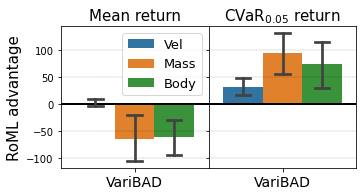

In [14]:
%%time
Mh, Xh = main_ratio(HUM_ENVS, sanity=(2,30));